In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf

# Introduction

A recent [paper](https://arxiv.org/pdf/1706.02515.pdf) titled "Self Normalizing Neural Networks" started getting a lot of buzz starting in June 2017. The main contribution of the paper was this new nonlinear activation function called a SELU (scaled exponential linear unit). You may recongize its similarity to the hugely popular RELU activation function, which has been the go-to nonlinearity for quite some time. 

In this notebook, we'll explore a performance comparison of RELU and SELU

Here a couple other great posts that looked at SELU performance. 
* https://github.com/shaohua0116/Activation-Visualization-Histogram
* https://github.com/kevinzakka/research-paper-notes/blob/master/snn.md

# Definitions

In [14]:
def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale*tf.where(x>0.0, x, alpha*tf.exp(x)-alpha)

# Normal Neural Net

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
numClasses = 10 # The number of categories the model is choosing from
inputSize = 784 # A 28x28 image will have 784 total pixel values
numHiddenUnits = 50 # Number of hidden units this one layer NN will have
trainingIterations = 10000 # Number of times the training loop is run
batchSize = 100 # Represents how many images we feed in one training batch

In [18]:
tf.reset_default_graph() # Just to make sure that we start with a new graph
X = tf.placeholder(tf.float32, shape = [None, inputSize])
y = tf.placeholder(tf.float32, shape = [None, numClasses])

W1 = tf.Variable(tf.truncated_normal([inputSize, numHiddenUnits], stddev=0.1))
B1 = tf.Variable(tf.constant(0.1), [numHiddenUnits])
W2 = tf.Variable(tf.truncated_normal([numHiddenUnits, numClasses], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1), [numClasses])

hiddenLayerOutput = tf.matmul(X, W1) + B1
hiddenLayerOutput = tf.nn.relu(hiddenLayerOutput)
finalOutput = tf.matmul(hiddenLayerOutput, W2) + B2
finalOutput = tf.nn.relu(finalOutput)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = finalOutput))
opt = tf.train.GradientDescentOptimizer(learning_rate = .1).minimize(loss)

correct_prediction = tf.equal(tf.argmax(finalOutput,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

reluTrainLoss = []
for i in range(trainingIterations):
    batch = mnist.train.next_batch(batchSize)
    batchInput = batch[0]
    batchLabels = batch[1]
    _, trainingLoss = sess.run([opt, loss], feed_dict={X: batchInput, y: batchLabels})
    if i%10 == 0:
        reluTrainLoss.append(trainingLoss)
        if i%1000 == 0:
            trainAccuracy = accuracy.eval(session=sess, feed_dict={X: batchInput, y: batchLabels})
            print ("step %d, training accuracy %g"%(i, trainAccuracy))

step 0, training accuracy 0.11
step 1000, training accuracy 0.94
step 2000, training accuracy 0.91
step 3000, training accuracy 0.97
step 4000, training accuracy 0.95
step 5000, training accuracy 0.99
step 6000, training accuracy 0.96
step 7000, training accuracy 0.98
step 8000, training accuracy 0.99
step 9000, training accuracy 1


In [19]:
tf.reset_default_graph() # Just to make sure that we start with a new graph
X = tf.placeholder(tf.float32, shape = [None, inputSize])
y = tf.placeholder(tf.float32, shape = [None, numClasses])

W1 = tf.Variable(tf.truncated_normal([inputSize, numHiddenUnits], stddev=0.1))
B1 = tf.Variable(tf.constant(0.1), [numHiddenUnits])
W2 = tf.Variable(tf.truncated_normal([numHiddenUnits, numClasses], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1), [numClasses])

hiddenLayerOutput = tf.matmul(X, W1) + B1
hiddenLayerOutput = selu(hiddenLayerOutput)
finalOutput = tf.matmul(hiddenLayerOutput, W2) + B2
finalOutput = selu(finalOutput)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = finalOutput))
opt = tf.train.GradientDescentOptimizer(learning_rate = .1).minimize(loss)

correct_prediction = tf.equal(tf.argmax(finalOutput,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

seluTrainLoss = []
for i in range(trainingIterations):
    batch = mnist.train.next_batch(batchSize)
    batchInput = batch[0]
    batchLabels = batch[1]
    _, trainingLoss = sess.run([opt, loss], feed_dict={X: batchInput, y: batchLabels})
    if i%10 == 0:
        seluTrainLoss.append(trainingLoss)
        if i%1000 == 0:
            trainAccuracy = accuracy.eval(session=sess, feed_dict={X: batchInput, y: batchLabels})
            print ("step %d, training accuracy %g"%(i, trainAccuracy))

step 0, training accuracy 0.24
step 1000, training accuracy 0.98
step 2000, training accuracy 0.95
step 3000, training accuracy 0.98
step 4000, training accuracy 1
step 5000, training accuracy 1
step 6000, training accuracy 0.97
step 7000, training accuracy 0.97
step 8000, training accuracy 0.97
step 9000, training accuracy 1


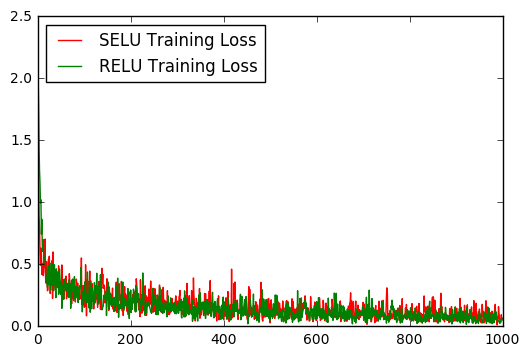

In [25]:
plt.gca().set_color_cycle(['red', 'green'])
plt.plot(seluTrainLoss)
plt.plot(reluTrainLoss)
plt.legend(['SELU Training Loss', 'RELU Training Loss'], loc='upper left')
plt.show()

# CNNs

In [26]:
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [38]:
tf.reset_default_graph() 
sess = tf.InteractiveSession()
x = tf.placeholder("float", shape = [None, 784]) 
y_ = tf.placeholder("float", shape = [None, 10]) 
x_image = tf.reshape(x, [-1,28,28,1])
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(.1, shape = [32]))
h_conv1 = tf.nn.conv2d(input=x_image, filter=W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
h_conv1 = tf.nn.relu(h_conv1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#Second Conv and Pool Layers
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(.1, shape = [64]))
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#First Fully Connected Layer
W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(.1, shape = [1024]))
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#Dropout Layer
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Second Fully Connected Layer
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(.1, shape = [10]))

#Softmax Layer
y_conv=(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#Cross Entropy Loss Function
crossEntropyLoss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y_conv))
trainStep = tf.train.AdamOptimizer().minimize(crossEntropyLoss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())

reluTrainLoss = []
batchSize = 50
for i in range(500):
    batch = mnist.train.next_batch(batchSize)
    trainingInputs = batch[0]
    trainingLabels = batch[1]
    _, trainingLoss = sess.run([trainStep, crossEntropyLoss], feed_dict={x: trainingInputs, y_: trainingLabels, keep_prob: 0.5})
    if i%10 == 0:
        reluTrainLoss.append(trainingLoss)
    if i%100 == 0:
        trainAccuracy = accuracy.eval(session=sess, feed_dict={x:trainingInputs, y_: trainingLabels, keep_prob: 1.0})
        print "step %d, training accuracy %g"%(i, trainAccuracy)

step 0, training accuracy 0.36
step 100, training accuracy 0.92
step 200, training accuracy 0.96
step 300, training accuracy 0.98
step 400, training accuracy 0.94


In [39]:
tf.reset_default_graph() 
sess = tf.InteractiveSession()
x = tf.placeholder("float", shape = [None, 784]) 
y_ = tf.placeholder("float", shape = [None, 10]) 
x_image = tf.reshape(x, [-1,28,28,1])
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(.1, shape = [32]))
h_conv1 = tf.nn.conv2d(input=x_image, filter=W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
h_conv1 = selu(h_conv1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#Second Conv and Pool Layers
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(.1, shape = [64]))
h_conv2 = selu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#First Fully Connected Layer
W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(.1, shape = [1024]))
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = selu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#Dropout Layer
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Second Fully Connected Layer
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(.1, shape = [10]))

#Softmax Layer
y_conv=(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#Cross Entropy Loss Function
crossEntropyLoss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y_conv))
trainStep = tf.train.AdamOptimizer().minimize(crossEntropyLoss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())

seluTrainLoss = []
batchSize = 50
for i in range(500):
    batch = mnist.train.next_batch(batchSize)
    trainingInputs = batch[0]
    trainingLabels = batch[1]
    _, trainingLoss = sess.run([trainStep, crossEntropyLoss], feed_dict={x: trainingInputs, y_: trainingLabels, keep_prob: 0.5})
    if i%10 == 0:
        seluTrainLoss.append(trainingLoss)
    if i%100 == 0:
        trainAccuracy = accuracy.eval(session=sess, feed_dict={x:trainingInputs, y_: trainingLabels, keep_prob: 1.0})
        print "step %d, training accuracy %g"%(i, trainAccuracy)

step 0, training accuracy 0.3
step 100, training accuracy 0.96
step 200, training accuracy 0.98
step 300, training accuracy 0.98
step 400, training accuracy 0.94


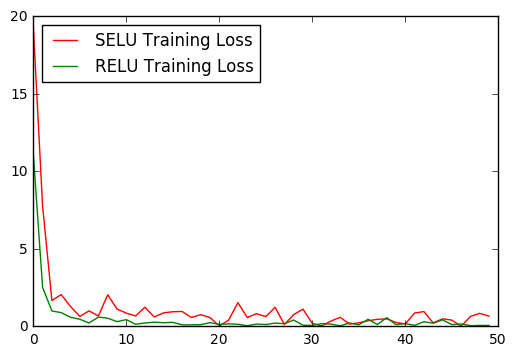

In [40]:
plt.gca().set_color_cycle(['red', 'green'])
plt.plot(seluTrainLoss)
plt.plot(reluTrainLoss)
plt.legend(['SELU Training Loss', 'RELU Training Loss'], loc='upper left')
plt.show()

LOL ^ That was unexpected, I need to make sure I didn't mess something up